# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [ ]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.23MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)#calocolo loss per ogni immagini, poi in loss viene salvato singolo valore loss media per batch
        loss.backward()#calola il gradiente della loss rispetto a ciascun peso del modello
        opt.step()#muove i pesi per minimizzare la loss
        losses.append(loss.item())#si aggiunge alla lista losses il valore di los per quella batch
    return np.mean(losses)#ritorna loss media per tutte la batch calcolate nell'epoca

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []#predizioni modello
    gts = []#ground truth
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        #model(xs) contiene le predizioni per ogni immagine nella batch. ha dime righe=immagini in batch, colonne=classi
        #torch.argmax restituisce il valore massimo per ogni riga, delle colonne. quindi la classe per ogni immagine, tensore (N,)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        #si appende alla lista delle predizioni tutte le predizioni delle immagini in batch, calcolate prima con preds
        #si stacca il tensore delle predizioni dal grafo computazioneale. cosi possiamo fare operazioni su questo senza influenzare il successivo calcolo del gradiente
        #poi ci spostiamo in cpu perche numpy lavora su quello e si trasforma il tensore in array per elaborarlo con numpy
        predictions.append(preds.detach().cpu().numpy())

    # Return accuracy score and classification report.
    #tuple: sequenze ordinate e immutabili di elementi.
    #la funzione evaluetion restituisce una tupla contenente accuracy_score ed classification_report.
    #classification report da precision, recall, F1-score, support per ogni classe
    #accuratezza calcolata confrontando le predizioni con le etichette.
    #np.hstack concatena le array di ogni singola batch creando un unico array per il dataset.
    #zero_division=dare valore 0 a calsse0. digits=numero di cifre decimali da visualizzare
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
#(x,_) ho una lista di tutple, considera il primo elemento per ogni tupla. (_,x) considera il secondo.
#plot_validation_curves si aspetta una lista di tuple. il primo elemento è loss media batch, secondo acc. media batch
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [ ]:
#Module è la classe base per tutti i moduli di reti neurali di pytorch.
#creiamo la classe MLP usando l'ereditarietà della classe Module, così ne avrà tutti gli attributi e metodi e può definirne i suoi.


class MLP(nn.Module):
    def __init__(self, layer_sizes):
        #chiama il costruttore della classe padre per inizializzare gli attributi ereditati.
        super().__init__()
        #crea un LISTA di layer lineari e li memorizza nell'attributo layers.
        #layer size_sizes è una lista che specifica il numero di neuroni per layer.

        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])

    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Training epoch 99: 100%|██████████| 430/430 [00:10<00:00, 40.21it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.968     0.979     0.973       980
           1      0.982     0.986     0.984      1135
           2      0.938     0.937     0.937      1032
           3      0.930     0.930     0.930      1010
           4      0.945     0.954     0.949       982
           5      0.929     0.913     0.921       892
           6      0.953     0.966     0.959       958
           7      0.953     0.940     0.946      1028
           8      0.924     0.933     0.928       974
           9      0.943     0.927     0.935      1009

    accuracy                          0.947     10000
   macro avg      0.946     0.946     0.946     10000
weighted avg      0.947     0.947     0.947     10000



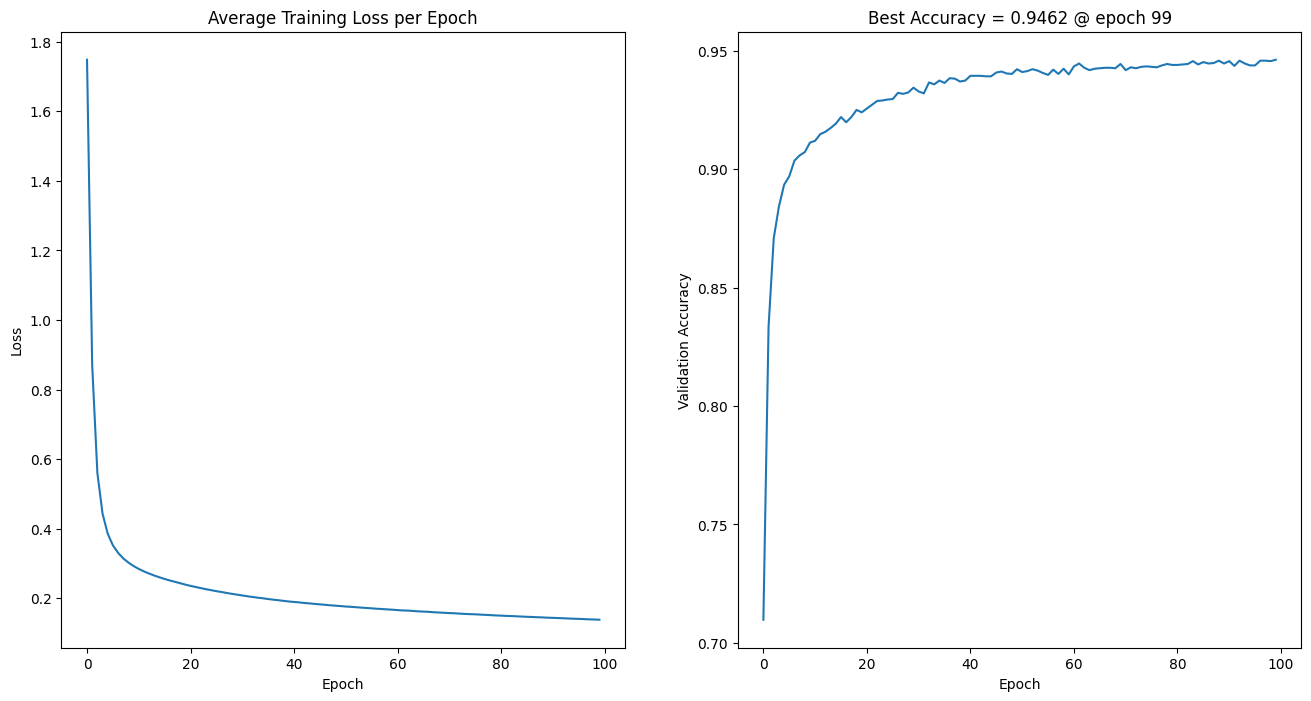

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [ ]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
import torch.optim as optim


In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
train_size = int(0.9*len(ds_train))
val_size = len(ds_train) - train_size
ds_train, ds_val = torch.utils.data.random_split(ds_train, [train_size, val_size])

#dataloader creation
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(ds_val, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.91MB/s]


In [ ]:
print(f"prind ds_train is {len(ds_train)}")
print(f"prind ds_val is {len(ds_val)}")
print(f"prind ds_len is {len(ds_test)}")
print(f"prind ds_train is {len(train_loader)}")#numero di batch


prind ds_train is 54000
prind ds_val is 6000
prind ds_len is 10000
prind ds_train is 422


In [ ]:
#model definition
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)#linear crea layer fully connected
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = x.view(-1, input_size)#trasforma immagine input in vettore da 28*28 a vettore 784, perchè gli specifico input size 784 e le altre dim le calcola lui
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x


In [ ]:
#training function and validation function definition
def train_mlp(model, train_loader, val_loader, epochs, lr):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  train_losses = []
  val_accuracies = []

  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    #batch_index è l'indice batch corrente.
    #enumerate restituisce una tupla con indice del batch e i dati ((data, target)) corrispettivi all'indice
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Training epoch {epoch + 1}')):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()#senno sommo i gradienti delle batch
      output = model(data)
      loss = F.cross_entropy(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss /= len(train_loader.dataset)#calcolo loss media dell'epoca, train_load.dataset è numero batch in trainloader
    train_losses.append(train_loss)

    model.eval()
    val_accuracy = 0.0
    with torch.no_grad():
       for data, target in val_loader:
           data, target = data.to(device), target.to(device)
           output = model(data)
           pred = output.argmax(dim=1, keepdim=True)
           val_accuracy += pred.eq(target.view_as(pred)).sum().item()

    val_accuracy /= len(val_loader.dataset)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

  return train_losses, val_accuracies


In [ ]:
#function of evaluation
def evaluate_model(model, test_loader):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  model.eval()
  predictions = []
  gts = []

  with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Evaluating'):
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)
      gts.extend(target.cpu().numpy())
      predictions.extend(pred.detach().cpu().numpy().flatten())

  return accuracy_score(np.hstack(gts), np.hstack(predictions)), classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3)


#plottiamo accuratezza e loss
def plot_validation_curves(train_losses, val_accuracies):
  losses = [x for x  in train_losses]
  accs = [x for x in val_accuracies]
  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Average Training Loss per Epoch')
  plt.subplot(1, 2, 2)
  plt.plot(accs)
  plt.xlabel('Epoch')
  plt.ylabel('Validation Accuracy')



In [ ]:
#create, train and evaluate mlp
input_size = 28 * 28
hidden_size = 16
output_size = 10
model = MLP(input_size, hidden_size, output_size)
epochs = 100
lr = 0.001

train_losses, val_accuracies = train_mlp(model,train_loader, val_loader, epochs, lr)

#plot loss and accuracy
plot_validation_curves(train_losses, val_accuracies)




In [ ]:
#evaluating model on testset
test_accuracy, classification_rep= evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Classification Report:\n', classification_rep)

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case.

In [ ]:
#un blocco residuale è l'insieme di più layer, all'uscita dell'ultimo layer del blocco si aggiunnge l'ingresso del blocco stesso.
class ResidualBlock(nn.Module):
  def __init__(self,input_size, hidden_size):
    super(ResidualBlock, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, input_size)

  def forward(self, x):
    idetity = x
    out = F.relu(self.fc1(x))
    out = self.fc2(out)
    out += idetity
    out = F.relu(out)
    return out

class ResidualMLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_blocks):
    super(ResidualMLP, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.blocks = nn.Sequential(*[ResidualBlock(hidden_size, hidden_size) for _ in range(num_blocks)])
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
        x = x.view(-1, input_size)
        x = F.relu(self.fc1(x))
        x = self.blocks(x)
        x = self.fc2(x)
        return x





In [ ]:
#create, train and evaluate mlp
input_size = 28 * 28
hidden_size = 16
output_size = 10
num_blocks = 3
model = ResidualMLP(input_size, hidden_size, output_size, num_blocks)
epochs = 100
lr = 0.001

train_losses, val_accuracies = train_mlp(model,train_loader, val_loader, epochs, lr)

#plot loss and accuracy
plot_validation_curves(train_losses, val_accuracies)

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving.

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

#importo librerie e dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
import torch.optim as optim
import wandb
import copy
import torchvision.datasets as datasets

wandb.login()
print("Logged in to Weights & Biases")

def calculate_dataset_stats(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=False, num_workers=2)
    total_sum = torch.zeros(3)
    total_squared_sum = torch.zeros(3)
    num_pixels = 0
    for images, _ in loader:
        total_sum += torch.sum(images, dim=(0, 2, 3))
        total_squared_sum += torch.sum(images**2, dim=(0, 2, 3))
        num_pixels += images.shape[0] * images.shape[2] * images.shape[3]
    mean = total_sum / num_pixels
    std = torch.sqrt((total_squared_sum / num_pixels) - (mean**2))
    return mean, std

def prepare_cifar10_datasets(batch_size=128):
    transform_calc = transforms.Compose([transforms.ToTensor()])
    trainset_calc_stats = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_calc)
    mean, std = calculate_dataset_stats(trainset_calc_stats)

    transform_train_val = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    ds_train_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_val)
    ds_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_size = int(0.9 * len(ds_train_full))
    val_size = len(ds_train_full) - train_size
    ds_train, ds_val = torch.utils.data.random_split(ds_train_full, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, mean, std

# Esegui per calcolare mean e std E caricare CIFAR-10 dataloaders PRIMA di definire prepare_cifar100_datasets
train_loader, val_loader, test_loader, mean, std = prepare_cifar10_datasets(batch_size=128)

# Spostato da cella 1dt3eBoFDbKE
def prepare_cifar100_datasets(mean, std, batch_size=128):
    transform_cifar100 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    cifar100_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_cifar100)
    cifar100_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_cifar100)

    cifar100_train_loader = torch.utils.data.DataLoader(cifar100_train, batch_size=batch_size, shuffle=False, num_workers=2)
    cifar100_test_loader = torch.utils.data.DataLoader(cifar100_test, batch_size=batch_size, shuffle=False, num_workers=2)

    print("✅ CIFAR-100 caricato con successo.")
    return cifar100_train_loader, cifar100_test_loader

# Esegui per caricare CIFAR-100 dataloaders DOPO che mean e std sono stati calcolati
cifar100_train_loader, cifar100_test_loader = prepare_cifar100_datasets(mean, std, batch_size=128)

Logged in to Weights & Biases
✅ CIFAR-100 caricato con successo.


#definisco il modello

In [ ]:
class FlexibleCNN(nn.Module):
    def __init__(self, num_filters=[32, 64, 128], dropout_prob=0.2):
        super(FlexibleCNN, self).__init__()
        self.num_filters = num_filters
        self.dropout_prob = dropout_prob

        self.conv_blocks = nn.ModuleList()
        in_channels = 3
        for out_channels in num_filters:
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            self.conv_blocks.append(block)
            in_channels = out_channels

        self.flatten_dim = (32 // (2 ** len(num_filters))) ** 2 * num_filters[-1]
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

def build_model(config):
    return FlexibleCNN(
        num_filters=config.get("num_filters", [32, 64, 128]),
        dropout_prob=config.get("dropout", 0.2)
    )

#definisco la funzione di training

In [ ]:
def train_and_validate_epoch(model, data_loader, optimizer, device, is_train=True):
    model.train() if is_train else model.eval()
    desc = "Training" if is_train else "Validation"

    running_loss, correct_predictions, total_samples = 0.0, 0, 0

    with torch.set_grad_enabled(is_train):
        for data, target in tqdm(data_loader, desc=desc, leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct_predictions += pred.eq(target.view_as(pred)).sum().item()
            total_samples += data.size(0)

    return running_loss / total_samples, correct_predictions / total_samples

def train_model_with_config(config, model, train_loader, val_loader, project_name="cnn", entity_name="john17-universit-di-firenze"):
    run = wandb.init(project=project_name, entity=entity_name, config=config)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    all_train_losses, all_val_accuracies = [], []

    for epoch in range(config["epochs"]):
        train_loss, _ = train_and_validate_epoch(model, train_loader, optimizer, device, is_train=True)
        val_loss, val_accuracy = train_and_validate_epoch(model, val_loader, optimizer, device, is_train=False)
        all_train_losses.append(train_loss)
        all_val_accuracies.append(val_accuracy)

        wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss, "val_accuracy": val_accuracy}, step=epoch+1)

    run.finish()
    return model, all_val_accuracies[-1]

#definisco la funzione di test

In [ ]:
def evaluate_model(model, test_loader, run):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device).eval()

    all_predictions, all_gts = [], []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            all_gts.append(target.cpu())
            all_predictions.append(pred.cpu())

    gts_np = torch.cat(all_gts).numpy()
    predictions_np = torch.cat(all_predictions).numpy().flatten()
    accuracy = accuracy_score(gts_np, predictions_np)
    report_str = classification_report(gts_np, predictions_np, zero_division=0, digits=3)

    if run is not None:
        run.log({"test_accuracy": accuracy, "classification_report_text": report_str})
        run.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=gts_np, preds=predictions_np, class_names=[str(i) for i in range(10)])})

    return accuracy, report_str


def plot_validation_curves(train_losses, val_accuracies, val_losses):
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(val_losses, color='orange')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Validation Loss')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(val_accuracies)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True)
    if len(val_accuracies) > 0:
        best_acc = np.max(val_accuracies)
        best_epoch = np.argmax(val_accuracies)
        plt.title(f'Val Accuracy (Best: {best_acc:.4f} @ Epoch {best_epoch + 1})')
        plt.plot(best_epoch, best_acc, 'ro')
    plt.tight_layout()
    plt.show()

#definisco funzione per salvare i logits

In [ ]:
def save_logits(model, dataloader, device):
    model.eval()
    model.to(device)
    logits = []
    labels = []

    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Salvataggio logits"):
            x = x.to(device)
            out = model(x)
            logits.append(out.cpu())
            labels.append(y)

    logits_tensor = torch.cat(logits)
    labels_tensor = torch.cat(labels)
    np.save("logits.npy", logits_tensor.numpy())
    np.save("labels.npy", labels_tensor.numpy())


#ciclo esperimenti più salvataggio teacher

In [ ]:
def run_experiments(config_list, train_loader, val_loader, test_loader, mean, std):
    best_acc = 0.0
    best_model = None
    best_config = None

    for config in config_list:
        print(f"\n🔧 Avvio esperimento con config: {config}")
        model = build_model(config)
        trained_model, val_acc = train_model_with_config(config, model, train_loader, val_loader)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(trained_model)
            best_config = config

    torch.save(best_model.state_dict(), "best_model.pt")
    print("✅ Modello migliore salvato in best_model.pt")

    #salviamo logits del teacher
    save_logits(best_model, train_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"))


    wandb_run = wandb.init(project="cnn_cifar10_improved", config=best_config)
    test_accuracy, classification_rep = evaluate_model(best_model, test_loader, wandb_run)
    print(f"Test Accuracy del modello migliore: {test_accuracy:.4f}")
    print("Classification Report:\n", classification_rep)

    best_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device)
    all_logits = []

    with torch.no_grad():
        for inputs, _ in tqdm(train_loader, desc="Teacher forward pass"):
            inputs = inputs.to(device)
            outputs = best_model(inputs)
            all_logits.append(outputs.cpu())

    all_logits = torch.cat(all_logits)
    torch.save(all_logits, "teacher_logits.pt")
    print("✅ Logits salvati in teacher_logits.pt")

    wandb_run.finish()
    return best_model, best_config

#esecuzione esperimenti

In [ ]:
if __name__ == "__main__":
    config_list = [
        {"num_filters": [32, 64], "dropout": 0.2, "epochs": 50, "learning_rate": 0.001, "weight_decay": 1e-4},
        {"num_filters": [32, 64, 128], "dropout": 0.3, "epochs": 50, "learning_rate": 0.001, "weight_decay": 1e-4},
        {"num_filters": [64, 128], "dropout": 0.25, "epochs": 50, "learning_rate": 0.0005, "weight_decay": 5e-4}
    ]

    train_loader, val_loader, test_loader, mean, std = prepare_datasets(batch_size=128)
    best_model, best_config = run_experiments(config_list, train_loader, val_loader, test_loader, mean, std)


100%|██████████| 170M/170M [00:03<00:00, 47.2MB/s]



🔧 Avvio esperimento con config: {'num_filters': [32, 64], 'dropout': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'weight_decay': 0.0001}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▆▆▅▆▆▆▆▇▆▆▇▇▇▇▇█▇▇█▇███▇█████████
val_loss,█▇▆▅▅▄▄▃▃▄▃▃▃▂▃▃▄▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂
epoch,50
train_loss,0.72066
val_accuracy,0.7354
val_loss,0.76998



🔧 Avvio esperimento con config: {'num_filters': [32, 64, 128], 'dropout': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'weight_decay': 0.0001}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▆▆▆▅▆▇▆▆▇▇▇▇▇▇▇▇██▇███████████▇██
val_loss,█▇▅▅▅▄▄▃▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▂▁▁
epoch,50
train_loss,0.49439
val_accuracy,0.8132
val_loss,0.55356



🔧 Avvio esperimento con config: {'num_filters': [64, 128], 'dropout': 0.25, 'epochs': 50, 'learning_rate': 0.0005, 'weight_decay': 0.0005}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▄▅▅▆▆▆▆▆▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▆█▇▇▇▇█▇▇████
val_loss,█▆▅▄▄▄▄▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▃▁▂▂▂▂▁▂▁▁▁▁▁▁
epoch,50
train_loss,0.74187
val_accuracy,0.7428
val_loss,0.74446


✅ Modello migliore salvato in best_model.pt


Salvataggio logits: 100%|██████████| 352/352 [00:15<00:00, 22.72it/s]


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 36.34it/s]


Test Accuracy del modello migliore: 0.8230
Classification Report:
               precision    recall  f1-score   support

           0      0.731     0.901     0.807      1000
           1      0.900     0.927     0.913      1000
           2      0.798     0.728     0.762      1000
           3      0.706     0.660     0.682      1000
           4      0.814     0.808     0.811      1000
           5      0.736     0.802     0.768      1000
           6      0.925     0.809     0.863      1000
           7      0.857     0.873     0.865      1000
           8      0.953     0.812     0.877      1000
           9      0.857     0.910     0.883      1000

    accuracy                          0.823     10000
   macro avg      0.828     0.823     0.823     10000
weighted avg      0.828     0.823     0.823     10000



Teacher forward pass: 100%|██████████| 352/352 [00:14<00:00, 23.68it/s]

✅ Logits salvati in teacher_logits.pt


test_accuracy,▁
classification_report_text,precis...
test_accuracy,0.823


#salviamo risultati in drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp best_model.pt /content/drive/MyDrive/
!cp logits.npy /content/drive/MyDrive/
!cp labels.npy /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat 'best_model.pt': No such file or directory
cp: cannot stat 'logits.npy': No such file or directory
cp: cannot stat 'labels.npy': No such file or directory


-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

Exercise 2.1: Fine-tune a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:

Use the pre-trained model as a feature extractor (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a classical approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a stable baseline performance on CIFAR-100 using the features extracted using your CNN.
Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
Unfreeze some of the earlier layers for fine-tuning.
Test different optimizers (Adam, SGD, etc.).
Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

#caricamento CIFAR-100

In [ ]:
# Carica il modello teacher (addestrato su CIFAR-10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Definisci il device qui
# Usa la configurazione migliore identificata (num_filters=[32, 64, 128], dropout_prob=0.3)
teacher_model = FlexibleCNN(num_filters=[32, 64, 128], dropout_prob=0.3)#miglior configurazione
teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/best_model.pt", map_location=device))
teacher_model.eval()
teacher_model.to(device)


# Calcola i logits del teacher su CIFAR-100
def get_teacher_logits(model, dataloader, device):
    model.eval()
    logits = []
    labels = []
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Teacher logits (CIFAR-100)"):
            x = x.to(device)
            out = model(x)
            logits.append(out.cpu())
            labels.append(y)
    return torch.cat(logits), torch.cat(labels)

# Verifica che cifar100_train_loader sia definito prima di usarlo
if 'cifar100_train_loader' in globals():
    teacher_logits_100, teacher_labels_100 = get_teacher_logits(teacher_model, cifar100_train_loader, device)

    # Salva su drive
    np.save("/content/drive/MyDrive/teacher_logits_cifar100.npy", teacher_logits_100.numpy())
    np.save("/content/drive/MyDrive/teacher_labels_cifar100.npy", teacher_labels_100.numpy())
    print("✅ Logits e labels del teacher su CIFAR-100 salvati.")
else:
    print("Errore: cifar100_train_loader non è definito. Assicurati che la cella che carica CIFAR-100 sia stata eseguita con successo.")

Teacher logits (CIFAR-100): 100%|██████████| 391/391 [00:13<00:00, 29.13it/s]

✅ Logits e labels del teacher su CIFAR-100 salvati.


#CNN distillation pipeline

In [ ]:
# 📤 2. Estrazione delle feature dal modello pre-addestrato


# Definizione manuale della best_config per evitare di rieseguire l'addestramento completo
# Questa configurazione è stata identificata come la migliore nell'esecuzione precedente della cella -r42_6aY-J_B
best_config = {"num_filters": [32, 64, 128], "dropout": 0.3, "epochs": 50, "learning_rate": 0.001, "weight_decay": 1e-4}
print(f"best_config definita manualmente: {best_config}")

def extract_features(model, dataloader, device):
    model.eval()
    model.to(device)
    features = []
    labels = []

    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Estrazione feature"):
            x = x.to(device)
            # Estrarre le attivazioni prima dell'ultimo layer FC
            for block in model.conv_blocks:
                x = block(x)
            x = x.view(x.size(0), -1)
            x = F.relu(model.fc1(x))  # opzionalmente aggiungere dropout
            features.append(x.cpu())
            labels.append(y)

    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()
    return features, labels


# --- 🔁 Uso pratico con best_config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ricostruzione del modello migliore con iperparametri salvati
# Assicurati che best_config sia definito eseguendo la cella degli esperimenti (-r42_6aY-J_B)
if 'best_config' not in globals():
    print("Errore: best_config non è definito. Assicurati di aver eseguito la cella degli esperimenti (-r42_6aY-J_B) prima di questa.")
else:
    best_model = FlexibleCNN(
        num_filters=best_config["num_filters"],
        dropout_prob=best_config["dropout"]
    )
    best_model.load_state_dict(torch.load("/content/drive/MyDrive/best_model.pt", map_location=device))

    # Estrazione feature su CIFAR-100
    # Assicurati che cifar100_train_loader e cifar100_test_loader siano stati definiti prima
    if 'cifar100_train_loader' in globals() and 'cifar100_test_loader' in globals():
        train_feats, train_labels = extract_features(best_model, cifar100_train_loader, device)
        test_feats, test_labels = extract_features(best_model, cifar100_test_loader, device)

        print("✅ Feature estratte con successo da CIFAR-100.")
    else:
        print("Errore: cifar100_train_loader o cifar100_test_loader non sono definiti. Assicurati che la cella che carica CIFAR-100 sia stata eseguita con successo.")

best_config definita manualmente: {'num_filters': [32, 64, 128], 'dropout': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'weight_decay': 0.0001}


Estrazione feature: 100%|██████████| 79/79 [00:02<00:00, 38.23it/s]

✅ Feature estratte con successo da CIFAR-100.


#addestro classificatore classico su features estratte

In [ ]:
# 🧪 3. Addestramento di un classificatore classico su feature estratte

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Scegli il classificatore
# clf = KNeighborsClassifier(n_neighbors=5)
clf = SVC(kernel='linear', C=1.0)

print("Inizio addestramento del classificatore classico (SVM)...")
# Addestra sull'insieme di training
clf.fit(train_feats, train_labels)
print("Addestramento completato.")

print("Inizio predizione sul test set...")
# Predici sul test set
preds = clf.predict(test_feats)
print("Predizione completata.")

# Valuta le prestazioni
acc = accuracy_score(test_labels, preds)
print(f"✅ Accuracy SVM su CIFAR-100: {acc:.4f}")

Inizio addestramento del classificatore classico (SVM)...
Addestramento completato.
Inizio predizione sul test set...
Predizione completata.
✅ Accuracy SVM su CIFAR-100: 0.2307


#finetuning modello su cifar-100

In [ ]:
# 🔧 4. Fine-tuning del modello su CIFAR-100

def fine_tune_model_on_cifar100(pretrained_model, num_classes=100, unfreeze_from=None):
    # Clona il modello e sostituisce il classificatore finale
    model = copy.deepcopy(pretrained_model)
    model.fc2 = nn.Linear(model.fc2.in_features, num_classes)

    # Congela tutti i parametri se non specificato diversamente
    for param in model.parameters():
        param.requires_grad = False

    # Sblocca dalla layer specificata in poi (es. conv_blocks[-1] o conv_blocks[-2:])
    if unfreeze_from is not None:
        for block in model.conv_blocks[unfreeze_from:]:
            for param in block.parameters():
                param.requires_grad = True

    # Sblocca anche la parte finale FC
    for param in model.fc1.parameters():
        param.requires_grad = True
    for param in model.fc2.parameters():
        param.requires_grad = True

    return model


#adestramento finale del modello fine-tunato su cifar-100

In [ ]:

# 📈 5. Addestramento finale del modello fine-tuned su CIFAR-100

# Esempio di configurazione per fine-tuning
finetune_config = {
    "num_filters": best_config["num_filters"],
    "dropout": best_config["dropout"],
    "epochs": 50,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4
}

# Ricrea il modello fine-tuned
model_ft = fine_tune_model_on_cifar100(best_model, num_classes=100, unfreeze_from=-1)

# Addestra il modello con la funzione già definita
model_ft, final_acc = train_model_with_config(
    config=finetune_config,
    model=model_ft,
    train_loader=cifar100_train_loader,
    val_loader=cifar100_test_loader,
    project_name="cnn_cifar100_finetuned",
    entity_name="john17-universit-di-firenze"
)

print(f"✅ Fine-tuning completato. Accuracy finale su CIFAR-100: {final_acc:.4f}")


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████████
val_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,1.27957
val_accuracy,0.5167
val_loss,1.80684


✅ Fine-tuning completato. Accuracy finale su CIFAR-100: 0.5167


#confronto grafico: classificatore vs modello fine-tunato

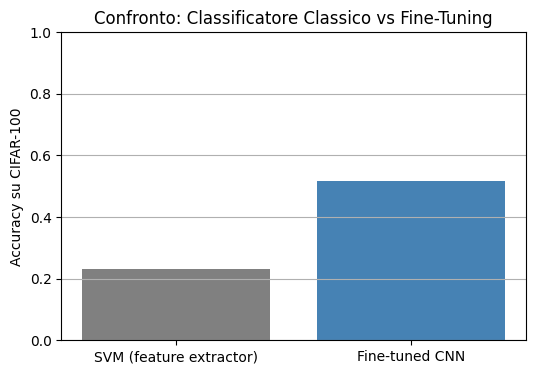

In [ ]:
 #📊 6. Confronto grafico: Classificatore classico vs Fine-tuned

import matplotlib.pyplot as plt

# Supponiamo che acc sia la accuracy dello SVM e final_acc quella del fine-tuning
model_names = ["SVM (feature extractor)", "Fine-tuned CNN"]
accuracies = [acc, final_acc]

plt.figure(figsize=(6, 4))
plt.bar(model_names, accuracies, color=["gray", "steelblue"])
plt.ylim(0, 1)
plt.ylabel("Accuracy su CIFAR-100")
plt.title("Confronto: Classificatore Classico vs Fine-Tuning")
plt.grid(axis='y')
plt.show()


### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [ ]:
# Questo codice è stato spostato nella cella 3c8baa0e-b17f-4a77-8a88-dadfdc6763ea
# per garantire che mean e std siano definiti prima del caricamento di CIFAR-100.

# 📦 1. Caricamento CIFAR-100 e Preprocessing (SPOSTATO)

# CIFAR-100 usa le stesse statistiche di normalizzazione calcolate su CIFAR-10
# transform_cifar100 = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)
# ])

# Dataset completo CIFAR-100
# cifar100_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_cifar100)
# cifar100_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_cifar100)

# Dataloader (batch size piccolo perché usiamo solo per estrarre feature)
# cifar100_train_loader = torch.utils.data.DataLoader(cifar100_train, batch_size=128, shuffle=False, num_workers=2)
# cifar100_test_loader = torch.utils.data.DataLoader(cifar100_test, batch_size=128, shuffle=False, num_workers=2)

# print("✅ CIFAR-100 caricato con successo.")

# Aggiunto un placeholder o una nota
print("Il codice di caricamento di CIFAR-100 è stato spostato nella cella precedente (quella che calcola mean e std).")

Il codice di caricamento di CIFAR-100 è stato spostato nella cella precedente (quella che calcola mean e std).


### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
# Your code here.